# Multi-Armed Bandits for Review Helpfulness

In this notebook we will train two machine learning models to classify amazon reviews, first using an Amazon SageMaker Pipeline, and second using a Hyperparameter Tuning Job.  When registered and approved in the Amazon SageMaker Model Registry, an MLOps A/B Testing Deployment pipeline will be triggered to create or update a multi-variant Amazon SageMaker endpoint.  You will then perform an A/B testing simulation and visualize the results to identify the best performing model.

We will be using the [spacy](https://spacy.io/) NLP library to tokenize the text and Amazon SageMaker [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) algorithm to train a classification model.

## Prerequisites

Prior to running this notebook, you will have:
1. Created the A/B Testing API and Infrastructure
2. Created an MLOPs A/B Testing Deployment project 

This notebook will take you thorugh a number of steps:
1. [Data Prep](#Data-Prep)
2. [Run SageMaker Pipeline](#Run-SageMaker-Pipeline)
3. [Run Tuning Job](#Run-Tuning-Job)
4. [Test Endpoint](#Test-Endpoint)
5. [Run A/B Testing Simulation](#Run-A/B-Testing-Simulation)
6. [Calling the winner](#Calling-the-winner)

In [2]:
%%capture
!pip install -U sagemaker pandas seaborn
!pip install spacy
!python -m spacy download en_core_web_sm

## Data Prep

Download a sample form the [Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) dataset

In [3]:
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz reviews.tsv.gz

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz to ./reviews.tsv.gz


Load the compressed reviews into pandas, selecting the review headling, body and star rating (should take approx 30 seconds)

In [4]:
%%time
import pandas as pd

# Load a sample of the rows
df_reviews = pd.read_csv('reviews.tsv.gz', compression='gzip', error_bad_lines=False, #nrows=1000,
                         sep='\t', usecols=['product_id', 'product_title',
                                            'review_headline', 'review_body', 'star_rating',
                                            'helpful_votes', 'total_votes']).dropna()
df_reviews.info()

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1312: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code, glob, local_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090980 entries, 0 to 3091102
Data columns (total 7 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   product_id       object
 1   product_title    object
 2   star_rating      int64 
 3   helpful_votes    int64 
 4   total_votes      int64 
 5   review_headline  object
 6   review_body      object
dtypes: int64(3), object(4)
memory usage: 188.7+ MB
CPU times: user 34.4 s, sys: 2.58 s, total: 36.9 s
Wall time: 37.6 s


Inspect the first few rows of the dataset

In [5]:
df_reviews.head()

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body
0,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,0,0,Five Stars,As described.
1,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,0,0,It works as advertising.,It works as advertising.
2,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,5,1,1,Five Stars,Works pissa
3,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,1,0,0,One Star,Did not work at all.
4,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,5,1,1,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...


### Feature engineering

Filter on reviews that have at least 5 votes, calculate a helpful score based  and rating sentiment.

In [6]:
df_reviews = df_reviews[df_reviews['total_votes'] >= 5]
df_reviews['helpful_score'] = df_reviews['helpful_votes'] / df_reviews['total_votes']
df_reviews['sentiment'] = pd.cut(df_reviews['star_rating'], bins=[0,2,3,6], labels=['Negative','Nuetral','Positive'])
df_reviews.describe()

,star_rating,helpful_votes,total_votes,helpful_score
count,291168.000000,291168.000000,291168.000000,291168.000000
mean,3.391341,15.939169,19.677993,0.741840
std,1.644254,67.884014,70.942305,0.279288
min,1.000000,0.000000,5.000000,0.000000
25%,2.000000,4.000000,6.000000,0.600000
50%,4.000000,7.000000,9.000000,0.833333
75%,5.000000,13.000000,16.000000,0.968750
max,5.000000,12786.000000,12944.000000,1.000000


Visualize the helpful score grouped by sentiment.  We can validate a high helpfulness count is correlated with strong negative or positive reviews.

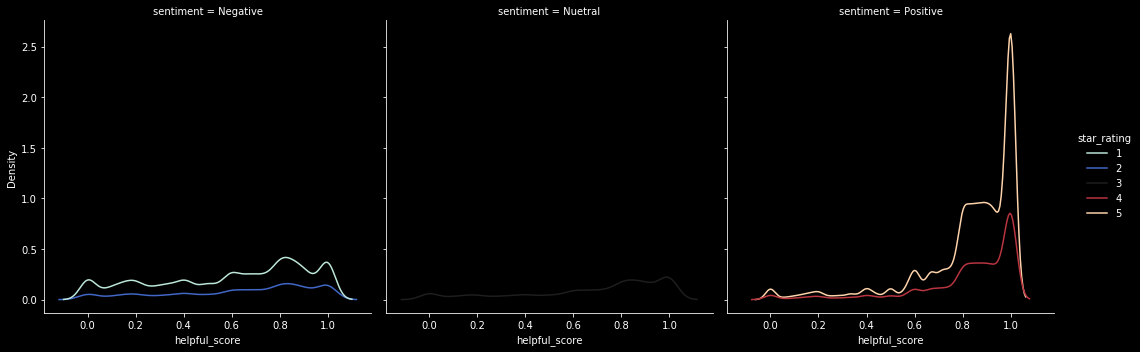

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")
sns.displot(df_reviews, x='helpful_score', col='sentiment', hue='star_rating', kind='kde', palette='icefire')

Group by the product and get the count of reviews, as well as sum of helpful and total votes.

In [8]:
df_votes =  df_reviews.groupby('product_id').agg({'product_id': 'count', 'helpful_votes': 'sum', 'total_votes': 'sum'})
df_votes.describe()

,product_id,helpful_votes,total_votes
count,52376.000000,52376.000000,52376.000000
mean,5.559187,88.608828,109.393654
std,12.490246,371.332497,437.566803
min,1.000000,0.000000,5.000000
25%,1.000000,6.000000,9.000000
50%,2.000000,17.000000,22.000000
75%,5.000000,58.000000,73.000000
max,638.000000,43288.000000,46228.000000


Filter on products that have at least 1 review and at least 5 helpful votes.

In [9]:
min_reviews = 1
min_helpful = 5
df_votes = df_votes[(df_votes['product_id']>=min_reviews) & (df_votes['helpful_votes']>=min_helpful)]

Merge reviews with minimum helpful votes 

In [10]:
df_reviews = df_reviews.merge(df_votes, how='inner', left_on='product_id', right_index=True, suffixes=('','_total'))
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284509 entries, 18 to 3091057
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   product_id           284509 non-null  object  
 1   product_title        284509 non-null  object  
 2   star_rating          284509 non-null  int64   
 3   helpful_votes        284509 non-null  int64   
 4   total_votes          284509 non-null  int64   
 5   review_headline      284509 non-null  object  
 6   review_body          284509 non-null  object  
 7   helpful_score        284509 non-null  float64 
 8   sentiment            284509 non-null  category
 9   product_id_total     284509 non-null  int64   
 10  helpful_votes_total  284509 non-null  int64   
 11  total_votes_total    284509 non-null  int64   
dtypes: category(1), float64(1), int64(6), object(4)
memory usage: 26.3+ MB


In [12]:
df_reviews.head()

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_score,sentiment,product_id_total,helpful_votes_total,total_votes_total
18,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,2,4,5,It does not copy CD-R s to USB as advertised ...,It does not copy CD-R s to USB as advertised. ...,0.800000,Negative,48,783,1088
43374,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,5,8,8,this Unit (TEAC CD-P650-B) is excellent. It is...,"For my purposes, this Unit (TEAC CD-P650-B) is...",1.000000,Positive,48,783,1088
50540,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,5,6,7,Even hooked up to my crappy receiver-it sounds...,I purchased this CD Player for my home (based ...,0.857143,Positive,48,783,1088
726034,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,2,0,14,What a disappointment that is,You do not make it clear that other components...,0.000000,Negative,48,783,1088
959377,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,5,7,8,Best BANG for your buck!!!,I am an audiophile & have good gear! bought th...,0.875000,Positive,48,783,1088


Pick a helpful score cut-off such that we have 50% helpful rating

In [13]:
df_reviews['is_helpful'] = (df_reviews['helpful_score'] > 0.80)
df_reviews['is_helpful'].sum()/df_reviews['is_helpful'].count()

0.5548471225866317

### Train/Test split

Split the dataset into train (90%) / validation (5%) / test (5%) and save to file local files.

In [15]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_reviews, test_size=0.1, random_state=42) 
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)
print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

split train: 256058, val: 14225, test: 14226 


Save the test dataset for evaluation

In [16]:
test_df.to_csv('test.csv', index=False, header=True)

Define functions to oiutput blazing text label and tokenized text from dataset

In [17]:
from spacy.lang.en import English

index_to_label = {0: 'NotHelpful', 1: 'Helpful'} 
nlp = English()
tokenizer = nlp.tokenizer

def labelize_df(df):
    return '__label__' + df['is_helpful'].apply(lambda is_helpful: index_to_label[is_helpful])

def tokenize_sent(sent, max_length=1000):
    return ' '.join([token.text for token in tokenizer(sent)])[:max_length]

def tokenize_df(df):
    return (df['review_headline'].apply(tokenize_sent) + ' ' + 
            df['review_body'].apply(tokenize_sent))

Test the lableize and tokenize output 

In [18]:
labelize_df(train_df.head(3)) + ' ' + tokenize_df(train_df.head(3))

2939355    __label__NotHelpful Fantastic speakers ; easy ...
2842286    __label__Helpful Handy Gadget , 3 Easy questio...
3062835    __label__NotHelpful Good player , bad software...
dtype: object

Create new pandas series that concatenates the label and tokenize values (this should less than 2 minutes)

In [19]:
%%time
train_text = labelize_df(train_df) + ' ' + tokenize_df(train_df)
val_text = labelize_df(val_df) + ' ' + tokenize_df(val_df)

CPU times: user 2min 4s, sys: 565 ms, total: 2min 5s
Wall time: 2min 5s


In [22]:
train_text

2939355    __label__NotHelpful Fantastic speakers ; easy ...
2842286    __label__Helpful Handy Gadget , 3 Easy questio...
3062835    __label__NotHelpful Good player , bad software...
2983811    __label__Helpful Quick and Easy ! This home ki...
1280514    __label__Helpful No more lip reading ! I wante...
                                 ...                        
2467086    __label__NotHelpful Cable Did n't work The cab...
3049690    __label__NotHelpful Too Expensive- Not enough ...
2204664    __label__Helpful Nice alternative to the offic...
3068900    __label__Helpful Expensive but worth it I had ...
1726091    __label__Helpful Not worth the hassle . If you...
Length: 256058, dtype: object

Save the tokenized pandas series as text without any header or index

In [23]:
%%time
train_text.to_csv('train.txt', index=False, header=False)
val_text.to_csv('validation.txt', index=False, header=False)

CPU times: user 3.65 s, sys: 125 ms, total: 3.77 s
Wall time: 4.83 s


### Upload Data

Upload data to s3 in bucket under a key prefix.

In [24]:
import sagemaker

# Get the session and default bucket
role = sagemaker.get_execution_role()
session = sagemaker.session.Session()
bucket = session.default_bucket()

# Set the prefix for this dataset
prefix = 'mab-reviews-helpfulness'

s3_train_uri = session.upload_data('train.txt', bucket, prefix + '/data/training')
s3_val_uri = session.upload_data('validation.txt', bucket, prefix + '/data/validation')
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Run SageMaker Pipeline

### Get Project

Set the project for your A/B testing pipeline

👇👇👇

In [25]:
project_name = 'ab-testing' # << Update this A/B testing deployment project

In [26]:
import boto3 
from botocore.config import Config

# Create SageMaker client with up to 10 retries
config = Config(retries={"max_attempts": 10, "mode": "standard"})
sm_client = boto3.client('sagemaker', config=config)

# Get the project name
response = sm_client.describe_project(ProjectName=project_name)
project_id = response['ProjectId']

# Define project tags which will be associated with pipeline, experiment and tuning job
project_tags = [
    {'Key': 'sagemaker:project-name', 'Value': project_name },
    {'Key': 'sagemaker:project-id', 'Value': project_id }
]

print(f"Project: {project_name} ({project_id})")

Project: ab-testing (p-7savmzladneb)


Create an experiment to associate training jobs to this project.

In [27]:
from botocore.exceptions import ClientError

def create_experiment():
    try:
        sm_client.create_experiment(
            ExperimentName=project_id,
            DisplayName=project_name,
            Description="A/B Testing Pipeline experiment",
            Tags=project_tags
        )
        print(f"Experiment '{project_id}' created")
    except ClientError as err:
        errcontent = err.response["Error"]
        if (errcontent["Code"] == "ValidationException" and "must be unique" in errcontent["Message"]): 
            print(f"Experiment '{project_id}' already exists")
        else:
            raise err

def create_trial(trial_name, display_name):
    try:
        sm_client.create_trial(
            TrialName=trial_name,
            DisplayName=display_name,
            ExperimentName=project_id,
            Tags=project_tags
        )
        print(f"Trial '{trial_name}' created")
    except ClientError as err:
        errcontent = err.response["Error"]
        if (errcontent["Code"] == "ValidationException" and "must be unique" in errcontent["Message"]):
            print(f"Trial '{trial_name}' already exists")
        else:
            raise err

create_experiment()

Experiment 'p-7savmzladneb' created


### Define the pipeline

Create a SageMaker pipeline to run the training job

In [28]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

training_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.c5.4xlarge"
)
training_instance_count = ParameterInteger(
    name="TrainingInstanceCount",
    default_value=1
)
input_train_data = ParameterString(
    name="InputDataTrain",
    default_value=s3_train_uri,
)
input_val_data = ParameterString(
    name="InputDataValidation",
    default_value=s3_val_uri,
)

Create the estimator that takes the input parameters

In [29]:
import boto3
from sagemaker.estimator import Estimator

region_name = boto3.Session().region_name
image_uri = sagemaker.image_uris.retrieve("blazingtext", region_name)

estimator = Estimator(image_uri=image_uri,
                      role=role, 
                      instance_count=training_instance_count, # Param
                      instance_type=training_instance_type, # Param
                      volume_size = 30,
                      max_run = 360000,
                      input_mode= 'File',
                      output_path=s3_output_location,
                      sagemaker_session=session)

estimator.set_hyperparameters(mode="supervised",
                              epochs=10,
                              min_epochs=5, # Min epochs before early stopping is introduced
                              early_stopping=True,
                              patience=2,
                              learning_rate=0.01,
                              min_count=2, # words that appear less than min_count are discarded 
                              word_ngrams=1, # the number of word n-gram features to use.
                              vector_dim=16, # dimensions of embedding layer
                              )

Now, let's create the steps. First the training step

In [30]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

step_train = TrainingStep(
    name="TrainModel",
    estimator=estimator,
    inputs={
        "train": TrainingInput(s3_data=input_train_data, content_type="text/plain"),
        "validation": TrainingInput(s3_data=input_val_data, content_type="text/plain"),
    },
)

Then, the Register step that will add a new version to the `champion` model package group in the Model Registry

In [31]:
from sagemaker.workflow.step_collections import RegisterModel

champion_model_group = f"{project_name}-champion"

step_register = RegisterModel(
    name="RegisterModel",
    estimator=estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/plain"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=champion_model_group
)

Now, we can create the pipeline.

In [32]:
from sagemaker.workflow.pipeline import Pipeline
import time

ts = time.strftime('%Y-%m-%d-%H-%M-%S')

pipeline_name = f"helpful-reviews-{ts}"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        training_instance_type,
        training_instance_count,        
        input_train_data,
        input_val_data
    ],
    steps=[step_train, step_register],
    sagemaker_session=session,
)

try:
    response = pipeline.create(role_arn=role)
except ClientError as e:
    error = e.response["Error"]
    if error["Code"] == "ValidationError" and "Pipeline names must be unique within" in error["Message"]:
        print(error["Message"])
        response = pipeline.describe()
    else:
        raise

pipeline_arn = response["PipelineArn"]

# Attach this to a specific project
tags = sm_client.add_tags(
    ResourceArn=pipeline_arn,
    Tags=project_tags
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


### Start Pipeline

And then, start pipeline and wait for it to complete.

In [33]:
start_response = pipeline.start(parameters={
    "TrainingInstanceCount": "1"
})

pipeline_execution_arn = start_response.arn

while True:
    resp = sm_client.describe_pipeline_execution(PipelineExecutionArn=pipeline_execution_arn)
    if resp['PipelineExecutionStatus'] == 'Executing':
        print('Running...')
    else:
        print(resp['PipelineExecutionStatus'])
        break
    time.sleep(15)

Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Succeeded


### Track Lineage

List lineage associated with the training job.

In [34]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sagemaker.session.Session())

# Get the training job 
steps = sm_client.list_pipeline_execution_steps(PipelineExecutionArn=pipeline_execution_arn)['PipelineExecutionSteps']
training_job_arn = [s['Metadata']['TrainingJob']['Arn'] for s in steps if s['StepName'] == 'TrainModel'][0]
        
viz.show(training_job_name=training_job_arn.split('/')[-1])

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...lpfulness/data/validation/validation.txt,Input,DataSet,ContributedTo,artifact
1,s3://...iews-helpfulness/data/training/train.txt,Input,DataSet,ContributedTo,artifact
2,81128...cr.us-east-1.amazonaws.com/blazingtext:1,Input,Image,ContributedTo,artifact
3,s3://...rainModel-ZFu7F8C6QR/output/model.tar.gz,Output,Model,Produced,artifact


Create an experiment trial for the pipeline, and associate the training jobs.

In [35]:
def associate_trial_component(source_arn, trial_name):
    for tc in sm_client.list_trial_components(SourceArn=source_arn)['TrialComponentSummaries']:
        print(f"Associated '{tc['TrialComponentName']}'")
        response = sm_client.associate_trial_component(
            TrialComponentName=tc['TrialComponentName'],
            TrialName=trial_name
        )

trial_name = f"{project_id}-pipeline"
create_trial(trial_name, "pipeline")
associate_trial_component(training_job_arn, trial_name)

Trial 'p-7savmzladneb-pipeline' created
Associated 'pipelines-cfxm668z5b1s-TrainModel-ZFu7F8C6QR-aws-training-job'


Then list the metrics for this experiment.

In [36]:
from sagemaker.analytics import ExperimentAnalytics
import pandas as pd

# Pick the key columns we are interested inv
analytics_df = ExperimentAnalytics(experiment_name=project_id).dataframe()

pd.set_option('display.max_colwidth', 100) # Increase column width to show full copmontent name
cols = ['TrialComponentName', 'SageMaker.InstanceType', 
        'train:accuracy - Last', 'validation:accuracy - Last'] # return the last accuracy for training and validation
analytics_df[cols].head(2)

,TrialComponentName,SageMaker.InstanceType,train:accuracy - Last,validation:accuracy - Last
0,pipelines-cfxm668z5b1s-TrainModel-ZFu7F8C6QR-aws-training-job,ml.c5.4xlarge,0.6828,0.6648


### Approve for deployment

Finally, approve the model to trigger the A/B testing deployment

In [37]:
# list all packages and select the latest one
packages = sm_client.list_model_packages(ModelPackageGroupName=champion_model_group,
                                        SortBy='CreationTime', SortOrder='Descending',
                                        MaxResults=1)['ModelPackageSummaryList']

# Approve the top model
for package in packages:
    latest_model_package_arn = package['ModelPackageArn']
    model_package_version = latest_model_package_arn.split('/')[-1]
    if package['ModelApprovalStatus'] == 'PendingManualApproval':
        print(f"Approving Champion Version: {model_package_version}")
        model_package_update_response = sm_client.update_model_package(
            ModelPackageArn=latest_model_package_arn,
            ModelApprovalStatus="Approved",
        )
    else:
        print(f"Champion Version: {model_package_version} approved")

Approving Champion Version: 1


## Run Tuning Job

To try and improve on our model, let's run a tuning job to find the parameters to maximize accuracy, and register this model.

### Setup Hyperparamter Tuning

Create the [Blazing Text](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) binary classifier for review helpfulness.

In [38]:
import boto3
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

region_name = boto3.Session().region_name
image_uri = sagemaker.image_uris.retrieve("blazingtext", region_name)
print(f'Using container: {image_uri}')

estimator = Estimator(image_uri,
                      role, 
                      instance_count=1, 
                      instance_type='ml.c5.4xlarge',
                      volume_size = 30,
                      max_run = 360000,
                      input_mode= 'File',
                      output_path=s3_output_location,
                      sagemaker_session=session)

estimator.set_hyperparameters(mode="supervised",
                              epochs=10,
                              min_epochs=5, # Min epochs before early stopping is introduced
                              early_stopping=False,
                              learning_rate=0.01,
                              min_count=2, # words that appear less than min_count are discarded 
                              word_ngrams=1, # the number of word n-gram features to use.
                              vector_dim=32, # dimensions of embedding layer
                             )

Using container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1


Tune an Amazon SageMaker BlazingText text classification model with the following [hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html).


| Parameter Name | Parameter Type | Recommended Ranges or Values | 
| --- | --- | --- | 
| buckets |  `IntegerParameterRange`  |  \[1000000\-10000000\]  | 
| epochs |  `IntegerParameterRange`  |  \[5\-15\]  | 
| learning\_rate |  `ContinuousParameterRange`  |  MinValue: 0\.005, MaxValue: 0\.01  | 
| min\_count |  `IntegerParameterRange`  |  \[0\-100\]  | 
| mode |  `CategoricalParameterRange`  |  \[`'supervised'`\]  | 
| vector\_dim |  `IntegerParameterRange`  |  \[32\-300\]  | 
| word\_ngrams |  `IntegerParameterRange`  |  \[1\-3\]  | 

In [39]:
hyperparameter_ranges = {'epochs': IntegerParameter(5, 50),
                        'learning_rate': ContinuousParameter(0.005, 0.01),
                        'min_count': IntegerParameter(0, 100),
                        'vector_dim': ContinuousParameter(1, 10),
                        'word_ngrams': IntegerParameter(1, 3),
                        'vector_dim': IntegerParameter(32, 300)}

Now, we'll create a `HyperparameterTuner` object, to which we pass:

* The `BlazingText` estimator we created above
* Our hyperparameter ranges
* Objective metric name and definition

Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [40]:
max_jobs = 9
objective_name = 'validation:accuracy'
tuner = HyperparameterTuner(estimator, 
                            objective_name,
                            hyperparameter_ranges,
                            tags=project_tags,
                            max_jobs=max_jobs,
                            max_parallel_jobs=3)

### Launch Tuning

Now we can launch a hyperparameter tuning job by calling `fit()` function.  After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed (will take approx 30 minutes).

In [41]:
input_train = TrainingInput(s3_data=s3_train_uri, content_type="text/plain")
input_val = TrainingInput(s3_data=s3_val_uri, content_type="text/plain")
data_channels = {'train': input_train, 'validation': input_val}

tuner.fit(inputs=data_channels)

..................................................................................................................................................................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [42]:
job_name = tuner.latest_tuning_job.job_name
tuning_job_status = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name)['HyperParameterTuningJobStatus']
if tuning_job_status != 'Completed':
    raise Exception(f'Tuning Jobs status is {tuning_job_status}')

### Analyse results

Get the top list of training jobs, sorted by the objective metric

In [43]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(job_name)
jobs_df = tuner_analytics.dataframe()
jobs_df = jobs_df[jobs_df['TrainingJobStatus'] == 'Completed'].sort_values('FinalObjectiveValue', ascending=False)
jobs_df.head()

,epochs,learning_rate,min_count,vector_dim,word_ngrams,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,23.0,0.009459,39.0,234.0,2.0,blazingtext-220412-0618-004-b9958b3a,Completed,0.6754,2022-04-12 06:23:15+00:00,2022-04-12 06:27:42+00:00,267.0
7,27.0,0.005596,93.0,262.0,1.0,blazingtext-220412-0618-002-8f9262aa,Completed,0.6711,2022-04-12 06:19:48+00:00,2022-04-12 06:20:50+00:00,62.0
1,30.0,0.009906,73.0,59.0,1.0,blazingtext-220412-0618-008-0568f555,Completed,0.6703,2022-04-12 06:29:17+00:00,2022-04-12 06:30:18+00:00,61.0
2,30.0,0.009906,75.0,59.0,1.0,blazingtext-220412-0618-007-e81bca70,Completed,0.6699,2022-04-12 06:28:50+00:00,2022-04-12 06:29:51+00:00,61.0
0,30.0,0.010000,73.0,53.0,1.0,blazingtext-220412-0618-009-218fe7d4,Completed,0.6695,2022-04-12 06:31:15+00:00,2022-04-12 06:32:55+00:00,100.0


You may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune.  

In [44]:
import bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

output_notebook()

class HoverHelper():
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )
        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

def compare_metrics(tuner_analytics, jobs_df):
    hover = HoverHelper(tuner_analytics)
    figures = []
    for hp_name, hp_range in tuner_analytics.tuning_ranges.items():
        categorical_args = {}
        if hp_range.get('Values'):
            # This is marked as categorical.  Check if all options are actually numbers.
            def is_num(x):
                try:
                    float(x)
                    return 1
                except:
                    return 0           
            vals = hp_range['Values']
            if sum([is_num(x) for x in vals]) == len(vals):
                # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
                print(f"Hyperparameter {hp_name} is tuned as categorical, but all values are numeric")
            else:
                # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
                categorical_args['x_range'] = vals

        # Now plot it
        p = figure(plot_width=500, plot_height=500, 
                   title=f"Objective vs {hp_name}",
                   tools=hover.tools(),
                   x_axis_label=hp_name, y_axis_label=objective_name,
                   **categorical_args)
        p.circle(source=jobs_df, x=hp_name, y='FinalObjectiveValue')
        figures.append(p)
    show(bokeh.layouts.Column(*figures))
    
compare_metrics(tuner_analytics, jobs_df)

Loading BokehJS ...

Create an experiment trial for the tuning job, and associate the training jobs (this will take < 20 seconds).

In [45]:
%%time

# Create the tuning trial
trial_name = f"{project_id}-tuning-job"
create_trial(trial_name, "tuning-job")

for i, tjs in enumerate(tuner_analytics.training_job_summaries()):
    associate_trial_component(tjs['TrainingJobArn'], trial_name)

Trial 'p-7savmzladneb-tuning-job' created
Associated 'blazingtext-220412-0618-009-218fe7d4-aws-training-job'
Associated 'blazingtext-220412-0618-008-0568f555-aws-training-job'
Associated 'blazingtext-220412-0618-007-e81bca70-aws-training-job'
Associated 'blazingtext-220412-0618-006-1dff8d55-aws-training-job'
Associated 'blazingtext-220412-0618-005-90e7c8eb-aws-training-job'
Associated 'blazingtext-220412-0618-004-b9958b3a-aws-training-job'
Associated 'blazingtext-220412-0618-003-a41f03c8-aws-training-job'
Associated 'blazingtext-220412-0618-002-8f9262aa-aws-training-job'
Associated 'blazingtext-220412-0618-001-38f5b69d-aws-training-job'
CPU times: user 215 ms, sys: 15 ms, total: 230 ms
Wall time: 10.8 s


### Register Model

Register and approve the best performing model in the `challenger` model package group in the Model Registry.

In [92]:
best_estimator = tuner.best_estimator()

challenger_model_group = f"{project_name}-challenger"

model_package = best_estimator.register(
    content_types=["text/plain"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=challenger_model_group,
    approval_status="Approved"
)

model_package_version = model_package.model_package_arn.split('/')[-1]
print(f"Registered and Approved Challenger Version: {model_package_version}")


2022-04-12 06:27:42 Starting - Preparing the instances for training
2022-04-12 06:27:42 Downloading - Downloading input data
2022-04-12 06:27:42 Training - Training image download completed. Training in progress.
2022-04-12 06:27:42 Uploading - Uploading generated training model
2022-04-12 06:27:42 Completed - Training job completed
Registered and Approved Challenger Version: 3


List the top `champion` and `challenger` approved models to verify that these have been approved.

In [96]:
cols = ['ModelPackageGroupName', 'ModelPackageVersion', 'CreationTime', 'ModelApprovalStatus']
champion_response = sm_client.list_model_packages(ModelPackageGroupName=champion_model_group)
challenger_response = sm_client.list_model_packages(ModelPackageGroupName=challenger_model_group)
champion_df = pd.DataFrame(champion_response['ModelPackageSummaryList'], columns=cols).head(1)
challenger_df = pd.DataFrame(challenger_response['ModelPackageSummaryList'], columns=cols).head(1)
pd.concat([champion_df, challenger_df])

,ModelPackageGroupName,ModelPackageVersion,CreationTime,ModelApprovalStatus
0,ab-testing-champion,2,2022-04-12 07:00:33.893000+00:00,Approved
0,ab-testing-challenger,3,2022-04-12 09:44:04.275000+00:00,Approved


You should now have an AWS CodePipeline job running that will update your endpoint with these latest models.

## Test Endpoint

### Invoke endpoint

Ensure that our endpoint is in service.  Set the `stage_name` here if not `dev`

👇👇👇

In [97]:
stage_name = 'dev' # << Update this with the stage name

endpoint_name = f'sagemaker-{project_name}-{stage_name}' 

endpoint_status = sm_client.describe_endpoint(EndpointName = endpoint_name)['EndpointStatus']
if endpoint_status != 'InService':
    raise Exception(f'Endpoint {endpoint_name} status is: {endpoint_status}')

Firstly we load back the test dataset that we held out during training.

In [98]:
import pandas as pd

test_df = pd.read_csv("test.csv")

Create a method to get predictions in batches

In [99]:
import boto3
import json

runtime = boto3.Session().client('sagemaker-runtime')

def chunker(seq, batch_size):
    return (seq[pos:pos + batch_size] for pos in range(0, len(seq), batch_size))

def parse_predictions(results):
    return [(result['label'][0] == '__label__Helpful', result['prob'][0]) for result in results]    

def predict(endpoint_name, variant_name, data, batch_size=50):
    all_predictions = []
    for array in chunker(data, batch_size):
        payload = {"instances" : array, "configuration": {"k": 1} }
        try:
            response = runtime.invoke_endpoint(
                EndpointName = endpoint_name, 
                TargetVariant = variant_name,
                ContentType = 'application/json',                        
                Body = json.dumps(payload))
            predictions = json.loads(response['Body'].read())            
            all_predictions += parse_predictions(predictions)
        except Exception as e:
            print(e)
            print(payload)
    return all_predictions

Get the variant names for the deployed endpoint

In [100]:
[pv['VariantName'] for pv in sm_client.describe_endpoint(EndpointName=endpoint_name)['ProductionVariants']]

['Champion2', 'Challenger3']

In [101]:
variant_names = [pv['VariantName'] for pv in sm_client.describe_endpoint(EndpointName=endpoint_name)['ProductionVariants']]
if len(variant_names) < 2:
    raise Exception('Require at least 2 variants for A/B Testing')

variant_names

['Champion2', 'Challenger3']

#### 두 개의 변형에 각각 추론

Make the predictions in batchs of 50 (should take < 20 seconds)

In [102]:
%%time
batch_size = 50
test_input = tokenize_df(test_df).to_list()

test_preds = [predict(endpoint_name, variant_name, test_input, batch_size) for variant_name in variant_names]

CPU times: user 6.89 s, sys: 113 ms, total: 7 s
Wall time: 16.1 s


In [120]:
import numpy as np
# print(test_input[0])
# print(test_preds[0][0])
print("Size of input: ", len(test_input))
print("Prediction Shape: ", np.asarray(test_preds).shape)


Size of input:  14226
Prediction Shape:  (2, 14226, 2)


Join the dataset with test set to evaluate performance

In [121]:
def join_test(test_df, predictions, variant_name):
    pred_df = pd.DataFrame(predictions, columns=['is_helpful_prediction', 'is_helpful_prob'])
    pred_df['variant_name'] = variant_name
    return test_df[['is_helpful']].join(pred_df)

# Create a combined dataset for each variant and output accuracy
join_df = pd.concat([join_test(test_df, predictions, variant_names[i]) for (i, predictions) in enumerate(test_preds)])

In [123]:
join_df.head(2)

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name
0,False,True,0.541072,Champion2
1,True,True,0.666277,Champion2


### Evaulate variants

Output the test accuracy metric for each variant

In [124]:
from sklearn.metrics import accuracy_score, f1_score

join_df.groupby('variant_name').apply(lambda g: accuracy_score(g['is_helpful_prediction'], g['is_helpful']))

variant_name
Challenger3    0.661535
Champion2      0.661535
dtype: float64

Get the confusion matrix for this binary classifier

Champion2 [[3814 2491]
 [2324 5597]]
Challenger3 [[3814 2491]
 [2324 5597]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


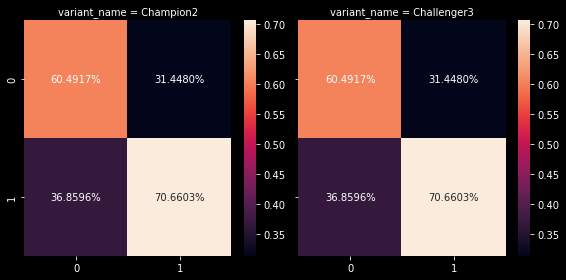

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def draw_heatmap(data, **kwargs):
    cf_matrix = confusion_matrix(data['is_helpful'], data['is_helpful_prediction'])
    print(data['variant_name'].unique()[0], cf_matrix)
    cf_percent = cf_matrix / cf_matrix.astype(np.float).sum(axis=1)
    sns.heatmap(cf_percent, annot=True, fmt=".4%")

fg = sns.FacetGrid(join_df, col='variant_name', height=4)
fg.map_dataframe(draw_heatmap)

Plot the ROC curve for the binary classification.

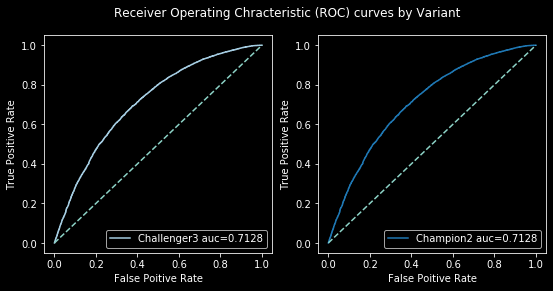

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(data):
    # Create horizontally stack plots (max is to to create at least 2 charts)
    fig, axs = plt.subplots(1, max(len(variant_names), 2), figsize=(9,4))
    fig.suptitle('Receiver Operating Chracteristic (ROC) curves by Variant')
    colors = sns.color_palette("Paired")
    # Plot the ROC curves by variant name
    for i, (variant_name, pred_df) in enumerate(data.groupby('variant_name')):        
        # Get true probability for ROC
        tp = pred_df.apply(lambda r: r['is_helpful_prob'] if r['is_helpful_prediction'] else 
                           1-r['is_helpful_prob'], axis=1)
        fpr, tpr, _ = roc_curve(pred_df['is_helpful'], tp)
        auc = roc_auc_score(pred_df['is_helpful'], tp)
        axs[i].plot(fpr,tpr,color=colors[i],label=f"{variant_name} auc={auc:.4f}")   
        axs[i].plot([0, 1], [0, 1], linestyle='--')
        axs[i].set_xlabel("False Poitive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].legend(loc=4)
        
plot_roc(join_df)

## Run A/B Testing Simulation

### Define API Methods

Set the REST API Endpoint to the value output in the AWS CloudFormation that creatied the A/B testing infrastructure.

👇👇👇

In [127]:
rest_api = 'https://3dn84vn0jc.execute-api.us-east-1.amazonaws.com/dev/' # << Update this with Rest API output

We can run a simulation by sending traffic to the REST API is a wrapper around your deployed SageMaker endpoint.  The API will

1. Assigning users to variants based on the **Multi-Armed Bandit** strategy configured for the `endpoint_name`.
2. Invoking the target endpoint variant, and capturing the `invocation` event.
3. Recording a `conversion` against a user with an optional `reward`.

We define some methods that to call the rest API using the python requests library:

In [128]:
import json
import os
import requests

def api_invocation(user_id, text_array):
    payload = {
        "user_id": str(user_id),
        "endpoint_name": endpoint_name, 
        "content_type": "application/json",
        "data": json.dumps({"instances" : text_array, "configuration": { "k": 1 }}), 
    }
    rest_url = os.path.join(rest_api, 'invocation')
    r = requests.post(rest_url, data=json.dumps(payload))
    return r.json()

def api_conversion(payload):
    rest_url = os.path.join(rest_api, 'conversion')
    r = requests.post(rest_url, data=json.dumps(payload))
    return r.json()

def api_stats():
    payload = {
        "endpoint_name": endpoint_name, 
    }
    rest_url = os.path.join(rest_api, 'stats')
    r = requests.post(rest_url, data=json.dumps(payload))
    return r.json()

Confirm that our metrics are all clear before we start our test.

In [129]:
api_stats()

{'endpoint_name': 'sagemaker-ab-testing-dev',
 'variant_metrics': [{'endpoint_name': 'sagemaker-ab-testing-dev',
   'variant_name': 'Champion2',
   'initial_variant_weight': 1.0,
   'invocation_count': 0,
   'conversion_count': 0,
   'reward_sum': 0.0},
  {'endpoint_name': 'sagemaker-ab-testing-dev',
   'variant_name': 'Challenger3',
   'initial_variant_weight': 1.0,
   'invocation_count': 0,
   'conversion_count': 0,
   'reward_sum': 0.0}],
 'strategy': 'ThompsonSampling',
 'epsilon': 0.1,
 'warmup': 0}

Create a small batches of inputs and test results, to find the most helpful review per batch

## Unit Testing

### api_predict()
- batch 사이즈 만큼을 추론 함. (예: batch_size = 20)
reward 의 정의는 진실값읜 "is_helpful"가 예측 결과와 같으면 "1" 을 부여 하는 것으로 정의 
```
['is_helpful'] == ['is_helpful_prediction']
```
- 20개의 예측을 'is_helpful_prediction', 'is_helpful_prob' 로 정렬하여 Top 1 만 추출
    - is_helpful_prediction == True 가 존재하면 결론적으로 reward 는 1 
- reward 가 0 이상이면 api_conversion () 호출
    
    
### Reward 정의 
reward 의 정의는 진실값읜 "is_helpful"가 예측 결과와 같으면 "1" 을 부여 하는 것으로 정의 
```
['is_helpful'] == ['is_helpful_prediction']
```
- Call invocation API with a batch of inputs, if the most helpful is matched with ground truth call conversion API.

In [273]:
batch_size = 3

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
len(input_batch), len(test_batch)

(4742, 4742)

In [292]:
from IPython.display import display as dp
def api_predict(i):
    result = api_invocation(i, input_batch[i])
    if 'predictions' in result:
        predictions = parse_predictions(result['predictions'])    
        # print("predictions: ", predictions)
        # Join predictions with test results
        pred_df = join_test(test_batch[i].reset_index(drop=True), predictions, result['endpoint_variant'])
        # Set the batch, invocattion and reward fields
        pred_df['strategy'] = result['strategy']
        pred_df['batch'], pred_df['invocation'] = i, 1
        # Set the reward based on prediction having a probability above a threshold
        pred_df['reward'] = pred_df.apply(lambda r: r['is_helpful'] == r['is_helpful_prediction'], axis=1).astype(int)
        # Get top helpful review based on probability
        pred_top = pred_df.sort_values(['is_helpful_prediction', 'is_helpful_prob'], ascending=False).head(1)
        reward = float(pred_top['reward'].sum())
        # print("reward: ", reward)
        # print("pred_df: ", dp(pred_df))        
        # print("result: ", result)
        
        # Record converison if reward
        if reward > 0:
            print("call api_conversion: ")
            api_conversion({ **result, 'reward': reward })
        return pred_top
    else:
        print('error, no predictions', result)

Get predictions for the batch of results, output progress (this should take approx 2 minutes)

In [295]:
# batch_num 값으로 배치 수 조절 
batch_num = 10

In [296]:
# [ i for i in (range(len(input_batch))) if i ==0  ]

# batch_df, num_api_conv = pd.concat(api_predict(i) for i in range(len(input_batch)) if i ==0 ).reset_index(drop=True)
batch_df = pd.concat(api_predict(i) for i in range(len(input_batch)) if i <= batch_num ).reset_index(drop=True)
batch_df 

call api_conversion: 
call api_conversion: 
call api_conversion: 
call api_conversion: 
call api_conversion: 
call api_conversion: 
call api_conversion: 
call api_conversion: 


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.666277,Challenger3,ThompsonSampling,0,1,1
1,True,True,0.520808,Challenger3,ThompsonSampling,1,1,1
2,True,True,0.638050,Challenger3,ThompsonSampling,2,1,1
3,True,True,0.579304,Challenger3,ThompsonSampling,3,1,1
4,False,True,0.644538,Champion2,ThompsonSampling,4,1,0
5,True,True,0.547001,Champion2,ThompsonSampling,5,1,1
6,True,True,0.500153,Champion2,ThompsonSampling,6,1,1
7,True,True,0.665619,Challenger3,ThompsonSampling,7,1,1
8,False,True,0.631101,Champion2,ThompsonSampling,8,1,0
9,True,True,0.715102,Challenger3,ThompsonSampling,9,1,1


## Batch 실행

In [259]:
from IPython.display import display as dp
def api_predict(i):
    result = api_invocation(i, input_batch[i])
    if 'predictions' in result:
        predictions = parse_predictions(result['predictions'])    
        # print("predictions: ", predictions)
        # Join predictions with test results
        pred_df = join_test(test_batch[i].reset_index(drop=True), predictions, result['endpoint_variant'])
        # Set the batch, invocattion and reward fields
        pred_df['strategy'] = result['strategy']
        pred_df['batch'], pred_df['invocation'] = i, 1
        # Set the reward based on prediction having a probability above a threshold
        pred_df['reward'] = pred_df.apply(lambda r: r['is_helpful'] == r['is_helpful_prediction'], axis=1).astype(int)
        # Get top helpful review based on probability
        pred_top = pred_df.sort_values(['is_helpful_prediction', 'is_helpful_prob'], ascending=False).head(1)
        reward = float(pred_top['reward'].sum())
        # print("reward: ", reward)
        # print("pred_df: ", dp(pred_df))        
        
        # Record converison if reward
        num_api_conversion = 0
        if reward > 0:
            # print("call api_conversion: ")
            num_api_conversion += 1
            api_conversion({ **result, 'reward': reward })
        return pred_top
    else:
        print('error, no predictions', result)

In [260]:
batch_size = 20

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
len(input_batch), len(test_batch)

(712, 712)

In [261]:
import tqdm.notebook as tq

batch_df = pd.concat(api_predict(i) for i in tq.tqdm(range(len(input_batch)))).reset_index(drop=True)

Output the bandit strategies used these invocations

In [262]:
batch_df.groupby(['variant_name', 'strategy'])['is_helpful_prediction'].count()

variant_name  strategy        
Challenger3   ThompsonSampling    376
Champion2     ThompsonSampling    336
Name: is_helpful_prediction, dtype: int64

### Visualize variant reward

Group the batch results by varianta rate to summarise the total number of invcations, reward and calculated rate.

In [263]:
variant_df = batch_df.groupby('variant_name').agg({
    'invocation': 'count', 
    'reward': 'sum'
})
variant_df['reward_rate'] = variant_df.apply(lambda r: r['reward']/r['invocation'], axis=1)
variant_df.sort_values('reward_rate', ascending=False)
variant_df

,invocation,reward,reward_rate
variant_name,,,
Challenger3,376,288,0.765957
Champion2,336,266,0.791667


- Add cummulative invocation and reward by variant to compare performance over batch
- reward rate reward / invocation 을 나눈 값

In [253]:
cum_df = batch_df.groupby(
    ['variant_name', 'batch'])[['invocation','reward']].sum().groupby(level=0).cumsum() #.reset_index()
cum_df['reward_rate'] = cum_df.apply(lambda r: 1.0 * r['reward'] / r['invocation'], axis=1)

- Graph the cumiative reward by variant
- 배치 시작 부터 끝까지의 reward 축적값을 보여 줌

Text(0.5, 1.0, 'Reward by Variant')

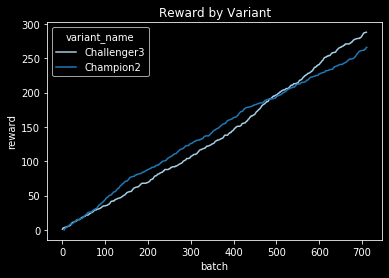

In [297]:
import seaborn as sns

sns.lineplot(data=cum_df, x="batch", y="reward", hue="variant_name", palette="Paired").set_title("Reward by Variant")

Graph the reward rate by variant

Text(0.5, 1.0, 'Reward Rate by Variant')

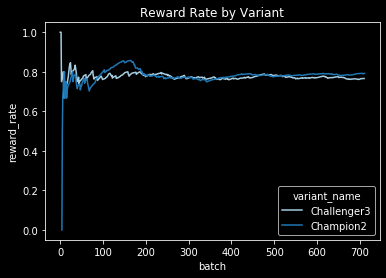

In [298]:
sns.lineplot(data=cum_df, x="batch", y="reward_rate", hue="variant_name", palette="Paired").set_title("Reward Rate by Variant")

### Plot Beta Distribution

Creates a series of 9 buckets to get invocation and reward for plotting 

In [299]:
# Cut the results into 9 bucket, and plot on a 3x3 chart
bucket = 9
beta_df = cum_df.reset_index()
beta_df['bucket'] = pd.cut(beta_df['batch'], [0,2,5,10,20,50,100,200,500,1000], right=True)
beta_df = beta_df.groupby(['variant_name', 'bucket'])[['invocation', 'reward']].max()

Plot the beta distribution for each bucket

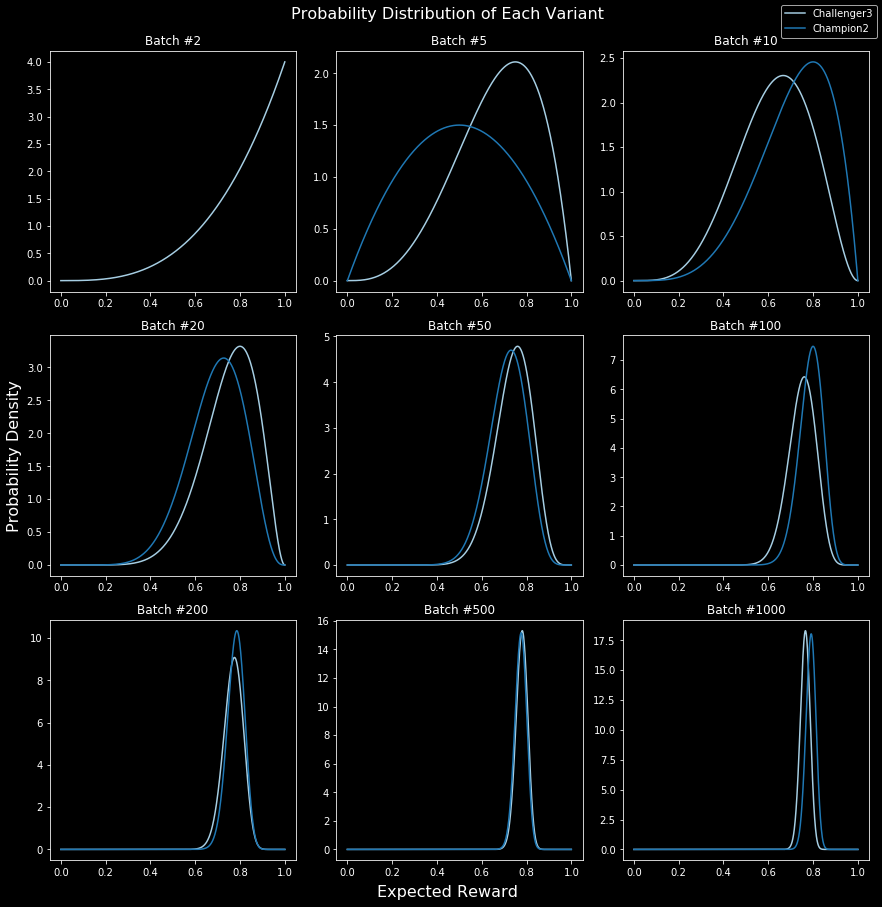

In [300]:
from scipy import stats

%matplotlib inline
colors = sns.color_palette("Paired")
plt.style.use("dark_background")

def plot_beta(beta_df):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    fig.suptitle('Probability Distribution of Each Variant', fontsize=16, y=1.02)
    fig.subplots_adjust(top=0.88)
    axs = axs.ravel()
    
    x = np.arange (0, 1.001, 0.001)
    for i, (b, bg) in enumerate(beta_df.groupby('bucket')):
        for j, (variant_name, vg) in enumerate(bg.groupby('variant_name')):
            v = vg.max()
            alpha, beta = 1+v['reward'], 1+v['invocation']-v['reward']
            axs[i].plot(x, stats.beta.pdf(x, alpha, beta), label=variant_name, color=colors[j])
        axs[i].set_title(f'Batch #{int(b.right)}')
        axs[i].grid(False)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.text(0.5, -.01, 'Expected Reward', ha='center', fontsize=16)
    fig.text(-.01, 0.5, 'Probability Density', va='center', fontsize=16, rotation='vertical')
    fig.tight_layout()
    plt.show()
    
plot_beta(beta_df)

## Calling the winner

Assuming a normal distribution, let's evaluate a confidence score for the best performing variant.

Challenger3 conversion rate (76.60%) is 3.25% lower than Champion2 rate (79.17%)


0.20426584553098426

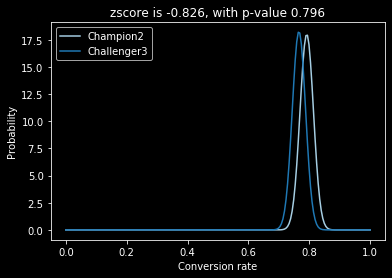

In [301]:
from scipy.stats import norm

def plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b):
    # Calculate the standard error for a and b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    p_value = norm().sf(z_score)
    conf = norm.cdf(z_score)
    # Plot distribution
    click_rate = np.linspace(0, 1.0, 200)
    prob_a = norm(rate_a, std_a).pdf(click_rate)
    prob_b = norm(rate_b, std_b).pdf(click_rate)    
    plt.plot(click_rate, prob_a, label=variant_a, color=colors[0])
    plt.plot(click_rate, prob_b, label=variant_b, color=colors[1])
    plt.legend(frameon=True)
    plt.xlabel("Conversion rate"); plt.ylabel("Probability");
    plt.title(f"zscore is {z_score:0.3f}, with p-value {p_value:0.3f}")
    return z_score, p_value, conf

# Lookup metrics for the variants
variant_a, variant_b = variant_names[:2]
rate_a, num_a = variant_df.loc[variant_a]['reward_rate'], variant_df.loc[variant_a]['invocation']
rate_b, num_b = variant_df.loc[variant_b]['reward_rate'], variant_df.loc[variant_b]['invocation']
rate_diff = (rate_b - rate_a) / rate_a
rate_dir = f'{rate_diff:.2%} higher' if rate_diff > 0 else f'{-rate_diff:.2%} lower'
print(f'{variant_b} conversion rate ({rate_b:.2%}) is {rate_dir} than {variant_a} rate ({rate_a:.2%})')

# Plot distribution and get confidence interval
z_score, p_value, conf = plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b)

if rate_diff > 0 and conf > 0.95:
    print(f'The result is statisticially significant')
conf

### Promote Model

If our new estimator is a winning model, we can register that model in the `Champion` model package group in the registry to trigger a new deployment with this single variant.

In [78]:
model_package = best_estimator.register(
    content_types=["text/plain"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=champion_model_group,
    approval_status="Approved"
)

model_package_version = model_package.model_package_arn.split('/')[-1]
print(f"Registered and Approved Champion Version: {model_package_version}")

Registered and Approved Champion Version: 2


## Monitoring

### Metrics

AWS CloudWatch metrics are published to every time metrics are updated in Amazon DynamoDB.

The following metrics are recorded against dimensions `EndpointName` and `VariantName` in namespace `aws/sagemaker/Endpoints/ab-testing`
* `Invocations`
* `Conversions`
* `Rewards`

### Traces

The API Lambda functions are instrumented with [AWS X-Ray](https://aws.amazon.com/xray/) so you can inspect the latency for all downstream services including
* DynamoDB
* Amazon SageMaker
* Kinesis Firehose

## Clean up

Start by deleting the AWS CloudFormation stack created to provision the SageMaker endpoint. 

In [ ]:
# deploy_stack =  f"sagemaker-{project_name}-deploy-{stage_name}"
# !aws cloudformation delete-stack --stack-name  $deploy_stack

Then empty the S3 bucket containing the artifacts output from the A/B Testing deployment pipeline.

In [ ]:
# s3_artifact_path = f"s3://sagemaker-{project_id}-artifact-{stage_name}-{region_name}"
# !aws s3 rm --recursive $s3_artifact_path

Once complete, delete the project which removes the AWS CloudFormation stack that created the CodePipeline.

In [ ]:
# !aws sagemaker delete-project --project-name $project_name